In [1]:
# Imports
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
import gensim

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn import metrics
from sklearn.model_selection import validation_curve

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from sklearn.model_selection import validation_curve


/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# Preprocess Data

# function to preprocess and tokenize text
def tokenize_corpus(txt, tokens_only=False):
    for i, line in enumerate(txt):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])
            
def doc2vector(vec_size, train_corpus, test_corpus):

    # tokenize a training corpus
    corpus_name = list(tokenize_corpus(train_corpus))

    # train doc2vec on the training corpus
    model = gensim.models.doc2vec.Doc2Vec(vector_size=vec_size, min_count=2, epochs=40)
    model.build_vocab(corpus_name)
    model.train(corpus_name, total_examples=model.corpus_count, epochs=model.epochs)

    # tokenize new documents
    doc = list(tokenize_corpus(test_corpus, tokens_only=True))

    # generate embeddings for the new documents
    x_test_name = np.zeros((len(doc),vec_size))
    for i in range(len(doc)):
        x_test_name[i,:] = model.infer_vector(doc[i])

    # check the shape of doc_emb
    print("Shape: " ,x_test_name.shape)
    
    return x_test_name


def preprocess(X_train_raw, X_test_raw):
    # Preprocessing data process
    
    ##### 1. name (string) -> Vectorise (50) #####

    print("Processing name")
    
    # doc2vectorise train and test data
    X_train_name_doc2vec = doc2vector(50, X_train_raw.name, X_train_raw.name)
    X_test_name_doc2vec = doc2vector(50, X_train_raw.name, X_test_raw.name)

    
    ##### 2. n_steps (int) -> Standardscaler #####
    
    print("Processing n_steps")

    n_steps_scaler = StandardScaler()

    # Get Data
    X_train_n_steps = X_train_raw.n_steps.values.reshape(-1,1)
    X_test_n_steps = X_test_raw.n_steps.values.reshape(-1,1)

    # Fit to scalar
    n_steps_scaler.fit(X_train_n_steps)
    
    # Transform train and test
    X_train_n_steps_scaled = n_steps_scaler.transform(X_train_n_steps)
    X_test_n_steps_scaled = n_steps_scaler.transform(X_test_n_steps)


    ##### 3. n_ingredients (int) -> Standardscaler #####

    print("Processing n_ingredients")
    
    n_ingredients_scaler = StandardScaler()

    # Get Data
    X_train_n_ingredients = X_train_raw.n_ingredients.values.reshape(-1,1)
    X_test_n_ingredients = X_test_raw.n_ingredients.values.reshape(-1,1)

    # Fit to scalar
    n_ingredients_scaler.fit(X_train_n_ingredients)
    
    # Transform train and test
    X_train_n_ingredients_scaled = n_ingredients_scaler.transform(X_train_n_ingredients)
    X_test_n_ingredients_scaled = n_ingredients_scaler.transform(X_test_n_ingredients)


    ##### 4. steps (list) -> Vectorise (200) #####
    
    print("Processing steps")

    # doc2vectorise it
    X_train_steps_doc2vec = doc2vector(50, X_train_raw.steps, X_train_raw.steps)
    X_test_steps_doc2vec = doc2vector(50, X_train_raw.steps, X_test_raw.steps)

    
    ##### 5. ingredients (list) -> doc2vec (100) #####
    
    print("Processing ingredients")
    
    #doc2vectorise it
    X_train_ingredients_doc2vec = doc2vector(50, X_train_raw.ingredients, X_train_raw.ingredients)
    X_test_ingredients_doc2vec = doc2vector(50, X_train_raw.ingredients, X_test_raw.ingredients)
    
    X_train_vars = [
        X_train_name_doc2vec,
        X_train_n_steps_scaled,
        X_train_n_ingredients_scaled,
        X_train_steps_doc2vec,
        X_train_ingredients_doc2vec
    ]

    X_test_vars = [
        X_test_name_doc2vec,
        X_test_n_steps_scaled,
        X_test_n_ingredients_scaled,
        X_test_steps_doc2vec,
        X_test_ingredients_doc2vec
    ]
    
    print("Concatenating")
    for i in X_train_vars:
        print(i.shape)
    for i in X_test_vars:
        print(i.shape)

    X_train = np.concatenate(X_train_vars,axis=1)
    X_test = np.concatenate(X_test_vars,axis=1)
    
    return X_train, X_test

# Validation and Evaluation

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

import csv


def convert_to_kaggle(labels, filename):
    with open(filename, mode='w') as file:
        file_writer = csv.writer(file, delimiter=',')
        file_writer.writerow(['id','duration_label'])
        for i,label in enumerate(labels, start=1):
            file_writer.writerow([i,label])
            
    

In [4]:
# Read in Data

# Data consists of 5 Features:

# 1. name (string)
# 2. n_steps (int)
# 3. n_ingredients (int)
# 4. steps (list)
# 5. ingredients (list)

# And one label:
# duration_label (float, 1 d.p)

# Read in test and train data
train = pd.read_csv(r"raw_data/recipe_train.csv", index_col = False, delimiter = ',', header=0)
test = pd.read_csv(r"raw_data/recipe_test.csv", index_col = False, delimiter = ',', header=0)

#Separate train and test data in X and Y
X_train_raw = train[['name', 'n_steps', 'n_ingredients', 'steps', 'ingredients']]
y_train = train['duration_label']

X_test_raw = test

In [ ]:
X_train, X_test = preprocess(X_train_raw, X_test_raw)

In [ ]:
print(X_train.shape)
print(X_test.shape)

In [ ]:
# save numpy array as npz file
from numpy import asarray
from numpy import savez_compressed
# save to npy file
savez_compressed('X_train.npz', X_train)
savez_compressed('X_test.npz', X_test)

In [5]:
# load numpy array from npz file
from numpy import load
# load dict of arrays
X_train = load('X_train.npz')['arr_0']
X_test = load('X_test.npz')['arr_0']

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

# Random Forests Classifier

In [9]:
# Train Random Forests Classifier

params = {
    'n_estimators':[10,100,1000],
    'criterion':['gini','entropy'],
    'max_depth':[100,500,None],
}

# Initialise Random Forest Classifier
rfc = RandomForestClassifier()

# Step 1: GridSearchCV for Model Optimisation
clf_rf = GridSearchCV(rfc, params)
clf_rf.fit(X_train, y_train)



GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [100, 500, None],
                         'n_estimators': [10, 100, 1000]})

In [6]:
# Step 2: Train model on GridSearchCV Optimal Parameters


rfc_best_params = {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 128}
rfc = RandomForestClassifier()
rfc.set_params(**rfc_best_params)
rfc.fit(X_tr, y_tr)



RandomForestClassifier(criterion='entropy', n_estimators=128)

Feature: 0, Score: 0.00257
Feature: 1, Score: 0.00269
Feature: 2, Score: 0.00300
Feature: 3, Score: 0.00225
Feature: 4, Score: 0.00227
Feature: 5, Score: 0.00249
Feature: 6, Score: 0.00240
Feature: 7, Score: 0.00231
Feature: 8, Score: 0.00244
Feature: 9, Score: 0.00240
Feature: 10, Score: 0.00239
Feature: 11, Score: 0.00226
Feature: 12, Score: 0.00317
Feature: 13, Score: 0.00292
Feature: 14, Score: 0.00224
Feature: 15, Score: 0.00257
Feature: 16, Score: 0.00232
Feature: 17, Score: 0.00241
Feature: 18, Score: 0.00242
Feature: 19, Score: 0.00228
Feature: 20, Score: 0.00226
Feature: 21, Score: 0.00315
Feature: 22, Score: 0.00261
Feature: 23, Score: 0.00237
Feature: 24, Score: 0.00242
Feature: 25, Score: 0.00228
Feature: 26, Score: 0.00237
Feature: 27, Score: 0.00252
Feature: 28, Score: 0.00243
Feature: 29, Score: 0.00251
Feature: 30, Score: 0.00279
Feature: 31, Score: 0.00295
Feature: 32, Score: 0.00244
Feature: 33, Score: 0.00251
Feature: 34, Score: 0.00250
Feature: 35, Score: 0.00239
Fe

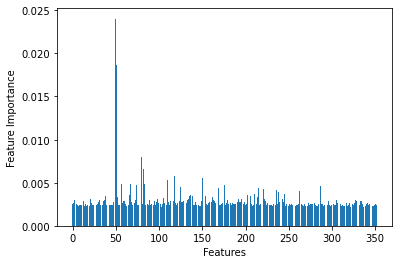

In [7]:
importance = rfc.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, ax = plt.subplots()
ax.bar([x for x in range(len(importance))], importance)

ax.set_ylabel("Feature Importance") # feature importance
ax.set_xlabel("Features")
plt.show()
fig.savefig("random_forest_feature_importance.png")

In [8]:
# Step 3: Output Prediction
res = rfc.predict(X_val)

print(confusion_matrix(y_val, res))
print(f1_score(y_val, res,average='macro'))
print(accuracy_score(y_val, res))
print(precision_score(y_val, res,average='macro'))
print(recall_score(y_val, res,average='macro'))

[[3473 2341    0]
 [1267 5445    0]
 [ 213  461    0]]
0.4577030616810827
0.6756060606060607
0.45381042818622125
0.46952827754414117


/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Gradient Boosted Multi-Classifier

In [ ]:
# Train XGBOOST Classifier

params = {
        'subsample': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

# Initialise Random Forest Classifier
gbc = GradientBoostingClassifier()

# Step 1: GridSearchCV for Model Optimisation

clf_gbc = GridSearchCV(gbc, params)
clf_gbc.fit(X_train, y_train)



In [9]:
# Step 2: Train model on GridSearchCV Optimal Parameters

#gbc_best_params = {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 128}

gbc = GradientBoostingClassifier()
gbc.fit(X_tr, y_tr)

GradientBoostingClassifier()

In [12]:
# Step 3: Output Prediction
res = gbc.predict(X_val)

In [13]:
print(confusion_matrix(y_val, res))
print(f1_score(y_val, res,average='macro'))
print(accuracy_score(y_val, res))
print(precision_score(y_val, res,average='macro'))
print(recall_score(y_val, res,average='macro'))

[[3957 1848    9]
 [1494 5192   26]
 [ 240  389   45]]
0.5138522933853679
0.6965151515151515
0.6522303794730927
0.506968020777622


# Train Logit Classifier

In [11]:
# Train Logistic Regression Classifier

params = {
    "penalty":['l1', 'l2', 'elasticnet', 'None' ],
    "C":np.logspace(-10,10,10),
    'solver':['newton-cg','lbfgs','liblinear','sag','saga'],
}

# Initialise Classifier
logit = LogisticRegression()

# Step 1: GridSearchCV for Model Optimisation
clf_logit = GridSearchCV(logit, params)
clf_logit.fit(X_train, y_train)

print("tuned hpyerparameters :(best parameters) ",clf_logit.best_params_)

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  warnings.warn("Estimator fit failed. The sco

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-tes

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  warnings.warn("Estimator fit failed. The sco

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Us

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  warnings.warn("Estimator fit failed. The sco

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 442, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver sag supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/Us

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 438, in _check_solver
    raise ValueError("Logistic Regression supports only penalties in %s,"
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  warnings.warn("Estimator fit failed. The sco

/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/johnnyqian/opt

tuned hpyerparameters :(best parameters)  {'C': 12.915496650148826, 'penalty': 'l2', 'solver': 'lbfgs'}


/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [49]:
# Step 2: Train model on GridSearchCV Optimal Parameters


logit_best_params = {'C': 13, 'penalty': 'l2', 'solver': 'lbfgs'}
logit = LogisticRegression()
logit.fit(X_tr, y_tr)

# Step 3: Output Prediction
res = logit.predict(X_val)

# Evaluation Metrics

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [8]:
logit_best_params = {'C': 13, 'penalty': 'l2', 'solver': 'lbfgs'}
logit = LogisticRegression()
logit.fit(X_tr, y_tr)
res = logit.predict(X_val)

print(res.shape)

(13200,)


/Users/johnnyqian/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Feature: 0, Score: -0.29071
Feature: 1, Score: 0.30696
Feature: 2, Score: -0.36464
Feature: 3, Score: -0.00794
Feature: 4, Score: 0.06267
Feature: 5, Score: 0.17256
Feature: 6, Score: -0.02903
Feature: 7, Score: 0.19212
Feature: 8, Score: -0.21668
Feature: 9, Score: -0.15418
Feature: 10, Score: 0.18861
Feature: 11, Score: 0.25322
Feature: 12, Score: -0.30337
Feature: 13, Score: 0.37811
Feature: 14, Score: -0.15504
Feature: 15, Score: -0.15636
Feature: 16, Score: -0.34838
Feature: 17, Score: 0.38889
Feature: 18, Score: 0.14489
Feature: 19, Score: 0.14203
Feature: 20, Score: 0.09978
Feature: 21, Score: -0.26753
Feature: 22, Score: 0.09655
Feature: 23, Score: -0.39262
Feature: 24, Score: -0.05689
Feature: 25, Score: -0.16035
Feature: 26, Score: 0.07070
Feature: 27, Score: 0.06271
Feature: 28, Score: 0.01990
Feature: 29, Score: -0.28709
Feature: 30, Score: 0.25330
Feature: 31, Score: -0.43562
Feature: 32, Score: -0.01809
Feature: 33, Score: -0.20212
Feature: 34, Score: 0.21026
Feature: 35,

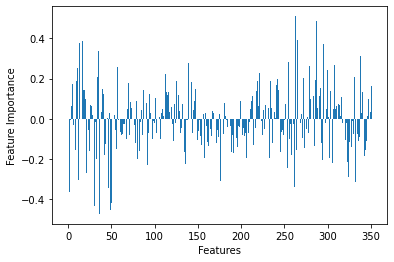

In [54]:
importance = logit.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
fig, ax = plt.subplots()
ax.bar([x for x in range(len(importance))], importance)

ax.set_ylabel("Feature Importance") # feature importance
ax.set_xlabel("Features")
plt.show()
fig.savefig("logit_feature_importance.png")

In [50]:
res = logit.predict(X_val)

print(confusion_matrix(y_val, res))
print(f1_score(y_val, res,average='macro'))
print(accuracy_score(y_val, res))
print(precision_score(y_val, res,average='macro'))
print(recall_score(y_val, res,average='macro'))

[[4279 1491   44]
 [1612 5002   98]
 [ 193  259  222]]
0.6300148785273536
0.7199242424242425
0.6846759431748496
0.6035304620965297


# Train KNN Classifier

In [ ]:
# Train KNN Classifier

params = {
}

# Initialise K-Nearest Neighbours Classifier
knc = KNeighborsClassifier()

# Step 1: GridSearchCV for Model Optimisation
clf_knc = GridSearchCV(knc, params)
clf_knc.fit(X_train, y_train)



In [51]:

# Step 2: Train model on GridSearchCV Optimal Parameters

knc_best_params = {}
knc = KNeighborsClassifier()
knc.fit(X_tr, y_tr)

# Step 3: Output Prediction
res = knc.predict(X_test)

In [52]:
res = knc.predict(X_val)

print(confusion_matrix(y_val, res))
print(f1_score(y_val, res,average='macro'))
print(accuracy_score(y_val, res))
print(precision_score(y_val, res,average='macro'))
print(recall_score(y_val, res,average='macro'))

[[5559  252    3]
 [5169 1507   36]
 [ 558   87   29]]
0.36017588149124974
0.5375
0.5784624784428561
0.40789676635445166


## Validation and Evaluation

In [ ]:

# Validation Curve vs Variable

param_range = [10,50,100]
train_scores, test_scores = validation_curve(RandomForestClassifier(), 
                                             X_train, 
                                             y_train, 
                                             param_name="n_estimators", 
                                             param_range=param_range,
                                             scoring="accuracy", 
                                             n_jobs=-1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
param_range = [10,50,100]

plt.title("Validation Curve with Random Forests Classifier")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

In [ ]:
%%time

n_models = 6
fig, axes = plt.subplots(3, n_models, figsize=(40, 15))

###### Random Forests

print("Validating/Evaluating Random Forests Classifier")

title = "Learning Curves (Random Forests Classifier)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 0],
                    cv=cv, n_jobs=-1)

###### XGBoost

print("Validating/Evaluating Gradient Boosting Classifier")

title = "Learning Curves (Gradient Boosting Classifier)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = GradientBoostingClassifier()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 1],
                    cv=cv, n_jobs=-1)

######

print("Validating/Evaluating Logistic Regression Classifier")

title = "Learning Curves (Logistic Regression Classifier)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = LogisticRegression()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 2],
                    cv=cv, n_jobs=-1)

######

print("Validating/Evaluating K-Neighbours Classifier")

title = "Learning Curves (KNN Classifier)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = KNeighborsClassifier()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 3],
                    cv=cv, n_jobs=-1)

######

print("Validating/Evaluating ExtraTrees Classifier")

title = "Learning Curves (ExtraTrees Classifier)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = ExtraTreesClassifier()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 4],
                    cv=cv, n_jobs=-1)

######

print("Validating/Evaluating MLP Classifier")

title = "Learning Curves (MLP Classifier)"
# Cross validation with 10 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

estimator = MLPClassifier()
plot_learning_curve(estimator, title, X_train, y_train, axes=axes[:, 5],
                    cv=cv, n_jobs=-1)

plt.show()

# Final Model Prediction

In [ ]:
logit = LogisticRegression()
logit.fit(X_train,y_train)
res = logit.predict(X_test)
convert_to_kaggle(res, "logit_pred.csv")